In [ ]:
# !pip install --upgrade jsonschema
import json
import pandas as pd
import seaborn
import warnings
import numpy as np
import operator
import sys
import matplotlib.pyplot as plt

from pandas.io.json import json_normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn import linear_model
from sklearn.metrics import make_scorer,mean_squared_error,r2_score,mean_absolute_error,accuracy_score, confusion_matrix
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.datasets import make_classification
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.cluster import KMeans


def pca(i, X_train, X_test, Y_train, Y_test, folds=0, dev=False):
    '''
    Perform Linear Regression on either train/validation set or on test set for PCA
    @params:
        i: number of components
        X_train, X_test, Y_train, Y_test: testing/training lists
        dev: set to true if doing validation testing; false if using test set data      
    '''

    # Perform PCA on data set
    pca = PCA(n_components=i)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    model = LinearRegression()

    # Linear regression on validation/train set
    if dev == True:
#         if i%10 == 0:
#             print('PCA validation -- fold {} -- component {}'.format(folds,i))
        train_pca, dev_pca, train_labels_pca, dev_labels_pca = train_test_split(X_train, Y_train, test_size=0.33, random_state=42)
        model.fit(train_pca, train_labels_pca)
        res_sum_square= np.mean((model.predict(dev_pca) - dev_labels_pca ** 2))
        var_val=model.score(dev_pca, dev_labels_pca)
        Y_test_predict = model.predict(dev_pca)
        r2_val=r2_score(dev_labels_pca,Y_test_predict)
        return model.intercept_,model.coef_,res_sum_square,var_val,r2_val

    # Linear regression on test set
    else:
#         if i%10 == 0:
#             print('PCA Test -- component {}'.format(i))
        model.fit(X_train, Y_train)
        res_sum_square= np.mean((model.predict(X_test) - Y_test ** 2))
        var_val=model.score(X_test, Y_test)
        Y_test_predict = model.predict(X_test)
        r2_val=r2_score(Y_test,Y_test_predict)
        return var_val, r2_val, X_train


def run_pca(component):
    ''' 
    Run PCA using k-fold cross validation strategy
    '''

    ### Preprocessing ###

    df = pd.read_csv('C:\\Users\\Kurly\\Downloads\\Universal-Embeddings-testing\\Universal-Embeddings-Nick\\data\\{}_data_clean.csv'.format(component))
    columns = list(df.columns.values)
    
    # Features list and removal of city, lat, lon
    features = list(df.columns.values)
    del features[:1]
    del features[-1]

    # y value list using last day of 7-month data
    y = df.loc[:, ['{}_2021_06_06'.format(component)]].values
#     y = df.loc[:, ['o3_2021_06_06'.format(component)]].values
    
    # Normalize x values
    x = df.loc[:, features].values
    x = Normalizer().fit_transform(x)

    # Number of features to compare
    num_of_comp=inp=list(range(2,191))

    ### Cross Validation ### 

    # k-fold cross validation; any cross-validation technique can be substituted here
    kfold = KFold(n_splits=5, shuffle=True)
    folds=0
    # Train/test and metrics for current component's set of datax =
    train_test_dict = {}
    metrics={}
    # Contains all train_test splits/metrics in PCA for n components and 
    # m sets of splits
    train_test_comp = {}
    metrics_comp = {}
    metrics_comp_set = {}

    # Loop through train/test data and save the best data with highest R2 scores
    for training_index, test_index in kfold.split(x):
        # Split X and Y train and test data
        X_train, X_test = x[training_index, :], x[test_index, :]
        Y_train, Y_test = y[training_index], y[test_index]
        folds+=1
        print('-----------------------------------------')
        # Update dict with train/test values
        train_test_dict['X_train'] = X_train
        train_test_dict['X_test'] = X_test
        train_test_dict['Y_train'] = Y_train
        train_test_dict['Y_test'] = Y_test
        # Save best sets of train/test data that have high R2 scores
        train_test_comp[folds] = train_test_dict.copy()
        
        # Train PCA and save a list of metrics 
        for i in num_of_comp:
            model_intercept, model_coef, res_sum_square, variance_score, Rsquare = pca(i, X_train, X_test, Y_train, Y_test, folds, dev=True)
            # Create metrics list for current comparison
            metrics['model_intercept']=model_intercept
            metrics['model_coef']=model_coef
            metrics['res_sum_square']=res_sum_square
            metrics['variance_score']=variance_score
            metrics['Rsquare']=Rsquare
            metrics_comp[i] = metrics.copy()
        # Save each metrics comparison for later
        metrics_comp_set[folds] = metrics_comp.copy()

    # Calculate the R2 score for each component
    best_r2 = -100
    sets = 0
    for i in metrics_comp_set:
        for j in metrics_comp_set[i]:
            R2 = metrics_comp_set[i][j]['Rsquare']
            #print('set : ' + str(i) + ' ' + 'comp' + ' ' + 
            #    str(j) + ' ' + 'Rsquare' + ' ' + str(R2))
            if R2 >= best_r2:
                best_r2 = R2
                sets=i
        
    # Graph PCA to test set with best components
    # using the best set to call PCA function to use the test set with all components
    pca_r2=[]
    pca_variance=[]
    # List of PCA encoded values to use in visualization
    
    # Obtain optimal PCA variance and R2 scores and add to list
    for i in train_test_comp:
        if i == sets:
            for j in train_test_comp[sets]:
                if 'X_test'==j:
                    X_ttbest=train_test_comp[sets][j]
                elif 'X_train' ==j:
                    X_tnbest=train_test_comp[sets][j]
                elif 'Y_test' ==j:
                    Y_ttbest=train_test_comp[sets][j]
                elif 'Y_train'==j:
                    Y_tnbest=train_test_comp[sets][j]
    print('-----------------------------------------')
    x3=X_train
    for i in num_of_comp:   
        variance, R2, X_train = pca(i, X_tnbest, X_ttbest, Y_tnbest ,Y_ttbest, folds, dev=False)
        pca_variance.append(variance)
        pca_r2.append(R2)

    return (pca_variance, pca_r2, X_train,x,x3)


def pca_linegraph(num_of_comp, component_names, colors_list):
    ''' 
    Plot a linegraph for pca
    '''
    plt.figure(figsize=(12,10))
    plt.rcParams.update({'font.size': 18})
    for i, component in enumerate(component_names):
        print('--- PCA on {} ---'.format(component))
        variance, r2, _ = run_pca(component)
        plt.plot(num_of_comp, variance, label = '{}'.format(component), linestyle = '-', marker = '+', color = colors_list[i])
        plt.plot(num_of_comp, r2, linestyle = '-.', marker = 'H', color = colors_list[i])
        plt.xlabel('Dimension')
        plt.ylabel('Percent Explained Variance')
        plt.title('PCA Reduced Representation of Air Pollutants')
        plt.legend()
    plt.show()
    

def pca_scatter(component, colors_list):
    '''
    PCA scatter plot of multiple components 
    '''
    
#     city_df = pd.read_csv(filepath_or_buffer='C:\\Users\\Kurly\\Downloads\\Universal-Embeddings-testing\\Universal-Embeddings-Nick\\data\\city_lat_lon.csv')
#     annotations = city_df.loc[:,'city']
    
    plt.figure(figsize=(12,12))
    plt.rcParams.update({'font.size': 18})

    print('--- PCA on {} ---'.format(component))
    pca_variance, pca_r2, X_train,x2,x3 = run_pca(component)
    print(X_train)
    plt.scatter(X_train[:,0], X_train[:,1], label='{}'.format(component), c=colors_list[0], alpha=0.1)

    size = len(X_train)
    plt.title('PCA scatter plot of CO')
    # Annotate points
    print('label maker')
    x2_l=len(x2)
    x3_l=len(x3)
    x2_list=[]
    for i in range (x2_l):
        for j in range (x3_l):
            if (x2[i]==x3[j]).all():
                x2_list.append(i)
    df = pd.read_csv('C:\\Users\\Kurly\\Downloads\\Universal-Embeddings-testing\\Universal-Embeddings-Nick\\data\\all_data_clean.csv')
    df1=df[['city']]
    list_l=len(x2_list)
    annotations = []
    for i in range (list_l):
        annotations.append(df1.loc[x2_list[i]]['city'])
    for i in range(size):
        if i%1000 == 0:
            X = X_train[i,0]
            Y = X_train[i,1]
            plt.annotate(text=annotations[i], xy=(X,Y))
    plt.show()
    return (x2,x3) 
    
def pca_kmeans(component, colors_list):
    '''
    kmeans clustering on a single gas
    '''

    plt.figure(figsize=(10,10))
    plt.rcParams.update({'font.size': 18})
    # Run PCA
    *_, X_train = run_pca('co')
    # Perform KMeans
    kmeans = KMeans(n_clusters=3)
    # Compute cluster centers and predict cluster indicies
    X_cluster = kmeans.fit_predict(X_train)

    label_color = [colors_list[i] for i in X_cluster]
    plt.scatter(X_train[:,0], X_train[:,2], c=label_color, alpha=0.5)
    plt.title('K-means Clustering of CO')
    plt.show()


### RUN ###

COMPONENT_NAMES = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
# COMPONENT_NAMES = ['o3']
# COMPONENT_NAMES = ['all',]
COLORS_LIST = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:purple', 'tab:cyan', 'tab:olive', 'tab:pink']
# All dimensions
# num_of_comp=inp=list(range(2,191))
num_of_comp=inp=list(range(2,1556))
# # First 25 dims
# comp_25 = list(range(2,27))
# # First 3 dims
# comp_3 = list(range(2,5))
# pca_linegraph(num_of_comp, COMPONENT_NAMES, COLORS_LIST)

# PCA scatter
pca_scatter(COMPONENT_NAMES[0], COLORS_LIST)

# PCA K-means
# pca_scatter('co', COLORS_LIST)

--- PCA on co ---
-----------------------------------------
-----------------------------------------
-----------------------------------------


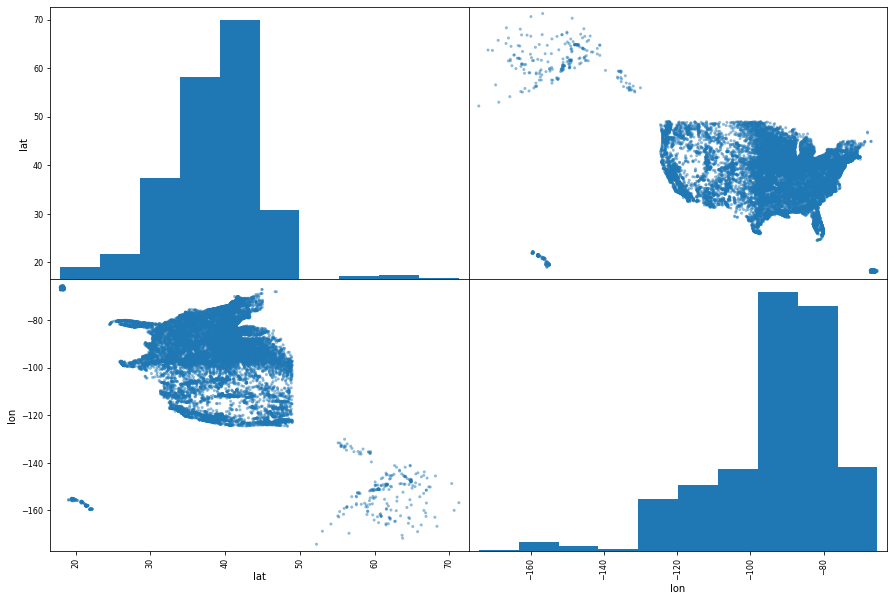

In [6]:
numeric_columns = ['lat', 'lon']
pd.plotting.scatter_matrix(df[numeric_columns], 
                             # Make figure large to show details
                             figsize = (15,10), 
                           # Lower point opacity to show overlap
                           alpha = 0.5)

plt.show()

In [55]:
print(x)
print(x2)
x_l=len(x)
x2_l=len(x2)
print(x_l)
print(x2_l)
one=100
count=0
x_list=[]
x2_list=[]
for i in range (x_l):
    for j in range (x2_l):
        if (x[i]==x2[j]).all():
            x_list.append(i)
            x2_list.append(j)
            count+=1
print(count)
print(x_list[9000],x2_list[9000])
print(x[17983],x2[9000])
df = pd.read_csv('C:\\Users\\Kurly\\Downloads\\Universal-Embeddings-testing\\Universal-Embeddings-Nick\\data\\all_data_clean.csv')
df1=df[['city']]
df1
count1=0
list_l=len(x_list)
alist = []
for i in range (list_l):
    alist.append(df1.loc[x_list[i]]['city'])
    count1+=1
count1
print(alist)

['Adair', 'Halliday', 'VanWert', 'Edgerton', 'Chupadero', 'Storden', 'Reevesville', 'Pennington', 'GoldHill', 'Cameron', 'Black', 'Standard', 'HayesCenter', 'Tuscumbia', 'BigIsland', 'YeehawJunction', 'CollegeSprings', 'Brinson', 'Gary', 'Vermilion', 'GuideRock', 'HaywoodCity', 'BluewaterAcres', 'EggHarbor', 'Tappen', 'Matoaka', 'Koliganek', 'TrailSide', 'DeSmet', 'Seaton', 'Garland', 'WhiteMountain', 'Chugwater', 'Haviland', 'Hull', 'Grantville', 'Samburg', 'SouthSalem', 'Tenstrike', 'Sellers', 'Mosby', 'Barkeyville', 'Parkersburg', 'Hallwood', 'Amasa', 'Jacksonport', 'Macy', 'Lewellen', 'Autryville', 'Belspring', 'Butters', 'Edenborn', 'Kellyton', 'Peterson', 'Fordville', 'Goodlow', 'Jeff', 'Westgate', 'Ellsworth', 'NorthRobinson', 'Petrolia', 'NewEdinburg', 'PaintRock', 'MillShoals', 'FishingCreek', 'Vaughnsville', 'Altona', 'GardenGrove', 'Scotia', 'Providence', 'SugarMountain', 'PecanGap', 'Raemon', 'NewtonHamilton', 'MountCory', 'Trumbull', 'Volga', 'Zanesfield', 'Sugartown', 'Ed